In [25]:
import pandas as pd
import numpy as np
import seaborn
import time
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from sklearn.model_selection import RandomizedSearchCV
import pymannkendall as mk
import geopandas as gpd
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [9]:
#1060 estuaries
estuary = pd.read_csv("list_1060_estuary.csv")

In [3]:
#Original  raw data
sr = pd.read_csv(r"D:\Estuary Temperature\global sr\final\Global_estuary_sr_clean_final_raw.csv")
sr = sr.drop_duplicates()
sr=sr[sr.ID_NUMBER.isin(estuary.ID_NUMBER)]
# Count the number of estuary detected by landsat
print("Number of Estuary",len(sr['ID_NUMBER'].unique()))
print("Number of sites",len(sr['p_ID'].unique()))
print(sr.shape)

Number of Estuary 1060
Number of sites 206560
(74697467, 34)


In [14]:
#Number of clean data
sr = pd.read_csv(r"D:\Estuary Temperature\global sr\final\Global_estuary_sr_clean_final_v3.csv", keep_default_na=False)
# Count the number of estuary detected by landsat
print("Number of Estuary",len(sr['ID_NUMBER'].unique()))
print("Number of sites",len(sr['p_ID'].unique()))
print("year min", sr['year'].min())
print("year min", sr['year'].max())
print(sr.shape)

Number of Estuary 1060
Number of sites 195566
year min 1985
year min 2022
(64375639, 27)


In [18]:
print(sr['date'].min(), sr['date'].max())

1985-01-01 2022-12-30


In [3]:
#sr[sr['CONTINENT'] == 'SA'].to_csv("SA_sr.csv", index=False)
#sr[sr['CONTINENT'] == 'AU'].to_csv("AU_sr.csv", index=False)
#sr[sr['CONTINENT'] == 'AS'].to_csv("AS_sr.csv", index=False)
#sr[sr['CONTINENT'] == 'AF'].to_csv("AF_sr.csv", index=False)
#sr[sr['CONTINENT'] == 'EU'].to_csv("EU_sr.csv", index=False)
#sr[sr['CONTINENT']==''].to_csv("NA_sr.csv", index=False)

In [4]:
print('Number of bad data', 64375639 - 74697467)
print( 'Percentage of bad data', 1 - 64375639/74697467)

Number of bad data -10321828
Percentage of bad data 0.13818176726126474


In [2]:
study_estuaries = pd.read_csv(r"D:\Estuary Temperature\global sr\final\test_each_estuary_final_V2.csv")
print(study_estuaries.shape)
print(study_estuaries[study_estuaries.INPUT_LAT>0].shape)

(737, 30)
(562, 30)


In [3]:
study_estuaries.groupby(['trend']).size()

trend
decreasing      2
increasing    346
no trend      389
dtype: int64

In [7]:
study_estuaries.slope.describe()

count    737.000000
mean       0.053083
std        0.057886
min       -0.220989
25%        0.025034
50%        0.048269
75%        0.077496
max        0.415511
Name: slope, dtype: float64

In [4]:
study_estuaries = study_estuaries[~(study_estuaries.trend=='no trend')]
print('CI',(1.96* np.std(study_estuaries ['slope'], ddof=1))/np.sqrt(study_estuaries ['slope'].shape[0]))
study_estuaries.slope.describe()

CI 0.004397805821323823


count    348.000000
mean       0.070071
std        0.041857
min       -0.084821
25%        0.044169
50%        0.060212
75%        0.084283
max        0.333085
Name: slope, dtype: float64

In [5]:
print(stats.mannwhitneyu(study_estuaries[study_estuaries.INPUT_LAT>0]['slope'],study_estuaries[study_estuaries.INPUT_LAT<0]['slope'], alternative='greater'))
print(study_estuaries[study_estuaries.INPUT_LAT>0]['slope'].shape)
print(279/346)
print(study_estuaries[study_estuaries.INPUT_LAT>0]['slope'].median())
print(study_estuaries[study_estuaries.INPUT_LAT<0]['slope'].median())

MannwhitneyuResult(statistic=15419.0, pvalue=4.892113884554498e-15)
(279,)
0.8063583815028902
0.0670212554574157
0.0400222007123718


<Figure size 1080x432 with 0 Axes>

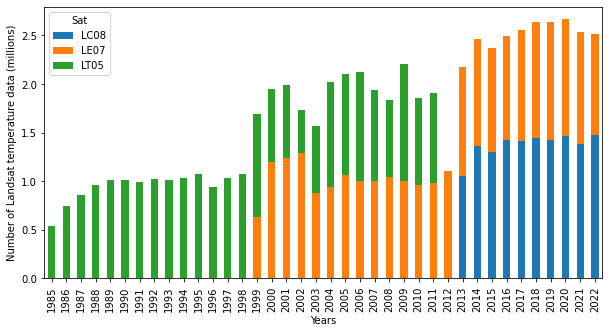

In [4]:
landsat = sr.groupby(['year','sat']).size().reset_index(name='count')
landsat['count'] =landsat['count']/1000000
landsat['Sat'] = landsat['sat'] 

plt.figure(figsize=(15,6))
ax = landsat.pivot(index="year", columns="Sat", values="count").plot(kind='bar', stacked=True, figsize=(10, 5))
ax.set_xlabel("Years")
ax.set_ylabel("Number of Landsat temperature data (millions)")
plt.savefig('number_of_landsat_.png')

In [ ]:
#Map global estuary
estuary_shp = geopandas.read_file(r"D:\Estuary Temperature\global sr\final\shp\estuary_centroid.shp")
estuary_shp = estuary_shp [estuary_shp.ID_NUMBER.isin(sr.ID_NUMBER.unique())]

# scatter points on the main axes
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig,main_ax  = plt.subplots(figsize=(15, 6))
worldmap.plot(color="white", ax=main_ax)
a = main_ax.scatter(estuary_shp['INPUT_LON'], estuary_shp['INPUT_LAT'],s=1, color='purple')
sns.set_style(rc = {'axes.facecolor': 'lightsteelblue'})
plt.rcParams["axes.grid"] = False

main_ax.set_xlabel("Longitude")
main_ax.set_ylabel("Latitude")

plt.savefig('1060_estuary_map.png')

(737, 30)


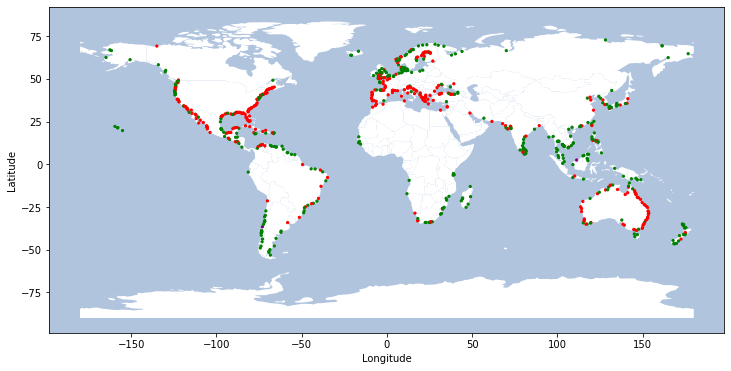

In [8]:
# Maps of all estuary 1060 estuary visualized by landsat observation

#Maps of study
study_estuaries = pd.read_csv(r"D:\Estuary Temperature\global sr\final\test_each_estuary_final_V2.csv")

worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig,main_ax  = plt.subplots(figsize=(15, 6))
worldmap.plot(color="white", ax=main_ax)

colors = {'increasing':'red', 'no trend':'green', 'decreasing':'purple'}
a = main_ax.scatter(study_estuaries['INPUT_LON'], study_estuaries['INPUT_LAT'],s=5, c=study_estuaries['trend'].map(colors))
sns.set_style(rc = {'axes.facecolor': 'lightsteelblue'})
plt.rcParams["axes.grid"] = False

main_ax.set_xlabel("Longitude")
main_ax.set_ylabel("Latitude")
plt.savefig('737_estuary_map.png')
print(study_estuaries.shape)

In [15]:
estuary_shp = geopandas.read_file(r"D:\Estuary Temperature\global sr\final\shp\estuary_centroid.shp")
def find_season(month, hemisphere):
    if hemisphere == 'Southern':
        season_month_south = {
            12:'Summer', 1:'Summer', 2:'Summer',
            3:'Autumn', 4:'Autumn', 5:'Autumn',
            6:'Winter', 7:'Winter', 8:'Winter',
            9:'Spring', 10:'Spring', 11:'Spring'}
        return season_month_south.get(month)
        
    elif hemisphere == 'Northern':
        season_month_north = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
        return season_month_north.get(month)
    else:
        print('Invalid selection. Please select a hemisphere and try again')


sr_year_estuary = sr[['ID_NUMBER', 'p_ID','year','month', 'Corrected_LS_Temp']]
sr_year_estuary = sr_year_estuary.merge(estuary_shp, on='ID_NUMBER', how='left')
south = sr_year_estuary[sr_year_estuary['INPUT_LAT'] <0]
north = sr_year_estuary[sr_year_estuary['INPUT_LAT'] >0]

season_list = []
hemisphere = 'Southern'
for month in south['month']:
    season = find_season(month, hemisphere)
    season_list.append(season)
    
south['Season'] = season_list

season_list = []
hemisphere = 'Southern'
for month in north['month']:
    season = find_season(month, hemisphere)
    season_list.append(season)
    
north['Season'] = season_list

sr_year_estuary = pd.concat([north, south])

high_estuary = sr_year_estuary[['ID_NUMBER', 'year', 'Season','INPUT_LAT']].drop_duplicates()
high_estuary = high_estuary [high_estuary.INPUT_LAT > 60.5]
print(len((high_estuary.ID_NUMBER).unique()))
high_estuary = high_estuary.groupby('Season').size().reset_index(name='Number of seasons')

#number of season
low_estuary = sr_year_estuary[['ID_NUMBER', 'year', 'Season','INPUT_LAT']].drop_duplicates()
low_estuary = low_estuary [low_estuary.INPUT_LAT < 60.5]
print(len((low_estuary.ID_NUMBER).unique()))
low_estuary = low_estuary.groupby('Season').size().reset_index(name='Number of seasons')



78
982


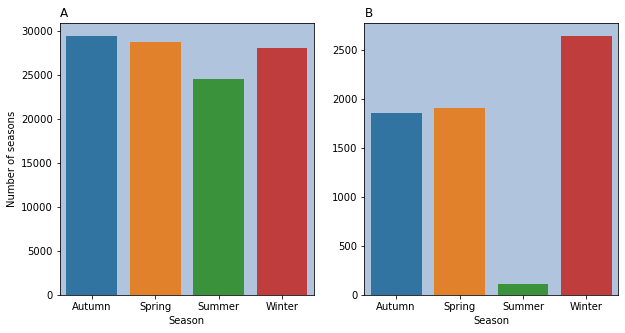

In [17]:
#Plot by season
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.barplot(y = low_estuary['Number of seasons'], x=low_estuary['Season'], ax=axes[0])
#plot by months
sns.barplot(y = high_estuary['Number of seasons'], x=low_estuary['Season'], ax=axes[1])
axes[1].set_ylabel(None)
#axes[1].set_xlabel(None)
axes[1].set_title("B", loc='left')
axes[0].set_title("A", loc='left')
plt.savefig('fig3_barplot.png')

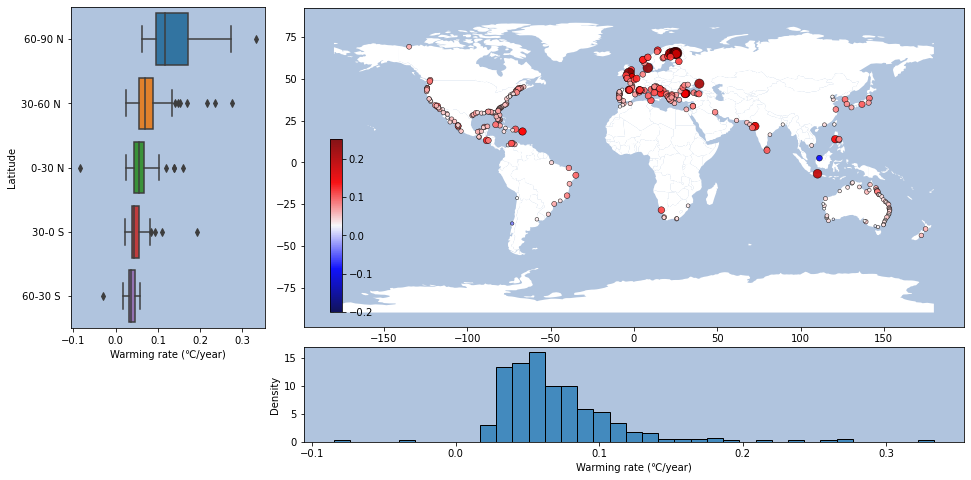

In [10]:
test_each_estuary = pd.read_csv(r"D:\Estuary Temperature\global sr\final\test_each_estuary_final_V2.csv")
test_each_estuary = test_each_estuary[~(test_each_estuary.trend=='no trend')]

 #Create some normally distributed data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# Set up the axes with gridspec
fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0])
x_hist = fig.add_subplot(grid[-1, 1:])

# scatter points on the main axes
worldmap.plot(color="white", ax=main_ax)
a = main_ax.scatter(test_each_estuary['INPUT_LON'], test_each_estuary['INPUT_LAT'], c=test_each_estuary['slope'], vmin=-0.2, vmax=0.25, alpha=0.9,s=400*np.abs(test_each_estuary['slope']),
            cmap='seismic',edgecolors='black', linewidth=0.5)
cbax = fig.add_axes([0.35, 0.35, 0.01, 0.3])
plt.colorbar(a, ax=main_ax, shrink=0.3, cax=cbax)

sns.boxplot(test_each_estuary['slope'], y=test_each_estuary['Latitude Zone'], ax=y_hist, order=['60-90 N','30-60 N ','0-30 N','30-0 S','60-30 S '])
sns.histplot(data=test_each_estuary, x='slope', ax=x_hist,stat="density")
y_hist.set_xlabel("Warming rate (℃/year)")
y_hist.set_ylabel("Latitude")
x_hist.set_xlabel("Warming rate (℃/year)")
sns.set_style(rc = {'axes.facecolor': 'lightsteelblue'})

#plt.savefig('fig3.png')

In [ ]:
from matplotlib.dates import DateFormatter

season = sr_year_estuary[['ID_NUMBER', 'p_ID','year','month','Season', 'Corrected_LS_Temp']].groupby(['ID_NUMBER',  'year','Season'])['Corrected_LS_Temp'].mean().reset_index()
season =season.groupby(['ID_NUMBER','year']).size().reset_index(name='counts')
season = season[season.counts >2]
season['key'] = season['ID_NUMBER'].astype(str) +"_"+ season['year'].astype(str) 

year = sr_year_estuary.groupby(['ID_NUMBER', 'p_ID', 'year','Season'])['Corrected_LS_Temp'].mean().reset_index()
year = year.groupby(['ID_NUMBER', 'year','Season'])['Corrected_LS_Temp'].mean().reset_index()

year = year.groupby(['ID_NUMBER', 'year'])['Corrected_LS_Temp'].mean().reset_index()
year['key'] = year['ID_NUMBER'].astype(str) +"_"+ year['year'].astype(str) 
year=year[year['key'].isin(season['key'])]

#More than 10 years of observation
count_years = year.groupby(['ID_NUMBER']).size().reset_index(name='counts')
count_years = count_years[count_years.counts > 10]
year = year[year['ID_NUMBER'].isin(count_years['ID_NUMBER'])]

e =year[year.ID_NUMBER== 4]
e["$Temperature {^\circ}C$"] = e["Corrected_LS_Temp"]
e['Year'] = e['year']
fig, axes = plt.subplots(2, 1, figsize=(10,5))
plt.subplots_adjust(hspace=0.5)

#plot_= sns.barplot(data=e, x="Year", y="$Temperature {^\circ}C$", color='steelblue', ax=axes[1])
plot_=sns.scatterplot(data=e, x="year", y="$Temperature {^\circ}C$", color='steelblue', ax=axes[1])
axes[1].axline((1985, 21), slope=0.023, color='C0', label='by slope')


a = sr[sr.p_ID==113119].sort_values(by=['date'])

a["$Temperature {^\circ}C$"] = a["Corrected_LS_Temp"]
a['Date'] = a['date']
plt.figure(figsize=(10,5))
ax2 = sns.lineplot(data=a, x="date", y="$Temperature {^\circ}C$", color='steelblue', ax=axes[0])
date_form = DateFormatter("%Y")
ax2.xaxis.set_major_formatter(date_form)
ax2.set_xticks(a['date'][::35])
ax2.set_xticklabels(a['date'][::35], rotation=30)
ax2.set_xlabel("")

fig.savefig("fig1.png")

#How many misssipi sites
print(len((sr[sr.ID_NUMBER== 4]['p_ID']).unique()))

In [11]:
test_each_estuary['slope'].describe()

count    348.000000
mean       0.070071
std        0.041857
min       -0.084821
25%        0.044169
50%        0.060212
75%        0.084283
max        0.333085
Name: slope, dtype: float64

In [12]:
test_each_estuary[['INPUT_LAT', 'slope']].corr()

#Calucalte the relationship between senslope and latitude
import statsmodels.api as sm
from sklearn import datasets

x = test_each_estuary.INPUT_LAT
y = test_each_estuary.slope

rlm_model = sm.OLS(y, sm.add_constant(x))
rlm_results = rlm_model.fit()
print(rlm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  slope   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     97.87
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           1.74e-20
Time:                        11:40:38   Log-Likelihood:                 654.43
No. Observations:                 348   AIC:                            -1305.
Df Residuals:                     346   BIC:                            -1297.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0526      0.003     19.777      0.0

In [13]:
air_temp_test = pd.read_csv(r"D:\Estuary Temperature\global sr\final\air_temp_test.csv")
b = test_each_estuary[['slope', 'ID_NUMBER']].merge(air_temp_test, on='ID_NUMBER', how='left')
b['slope_air'] = b['slope_y']
b['slope'] = b['slope_x']
b['trend_air'] = b['trend']

In [18]:
print(stats.mannwhitneyu(b[b.trend_air =="increasing"]['slope'],b[b.trend_air=="no trend"]['slope'], alternative='greater'))
b.groupby('trend_air')['slope'].median()

MannwhitneyuResult(statistic=14924.0, pvalue=1.6939926752796373e-06)


trend_air
increasing    0.065010
no trend      0.049562
Name: slope, dtype: float64

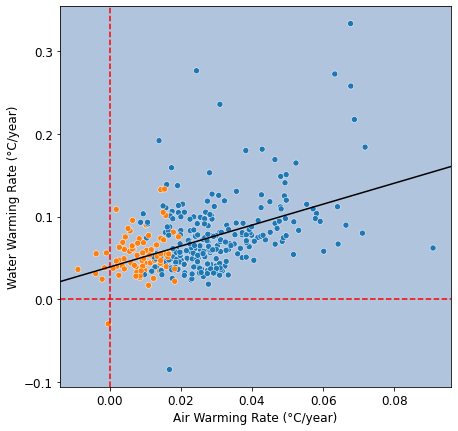

In [65]:
fig, ax = plt.subplots(figsize=(7, 7))

viol_plot = sns.scatterplot(data=b, x='slope_air', y='slope',hue='trend_air', ax=ax)
viol_plot.axvline(0, color='r', linestyle ="--")
viol_plot.axhline(0, color='r', linestyle ="--")

viol_plot.axline((0, 0.039 ), slope=1.2660, color='black', label='by slope')
viol_plot.set_xlabel('Air Warming Rate (°C/year)', fontsize = 12)
viol_plot.set_ylabel('Water Warming Rate (°C/year)', fontsize = 12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
viol_plot.get_legend().set_visible(False)
#plt.savefig('air and water slope.png')

In [69]:
bb = b.merge(estuary_shp, on='ID_NUMBER', how='left')
bb = bb[bb.INPUT_LAT < 60.5]
x = bb.slope_air
y = bb.slope

rlm_model = sm.OLS(y, sm.add_constant(x))
rlm_results = rlm_model.fit()
print(rlm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  slope   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     33.89
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           1.40e-08
Time:                        18:59:20   Log-Likelihood:                 653.37
No. Observations:                 326   AIC:                            -1303.
Df Residuals:                     324   BIC:                            -1295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0468      0.004     12.901      0.0

In [70]:
bb = b.merge(estuary_shp, on='ID_NUMBER', how='left')
bb = bb[bb.INPUT_LAT > 60.5]
x = bb.slope_air
y = bb.slope

rlm_model = sm.OLS(y, sm.add_constant(x))
rlm_results = rlm_model.fit()
print(rlm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  slope   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.305
Date:                Mon, 06 Nov 2023   Prob (F-statistic):              0.267
Time:                        18:59:23   Log-Likelihood:                 28.999
No. Observations:                  22   AIC:                            -54.00
Df Residuals:                      20   BIC:                            -51.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0738      0.063      1.176      0.2

(85, 32)
(263, 32)


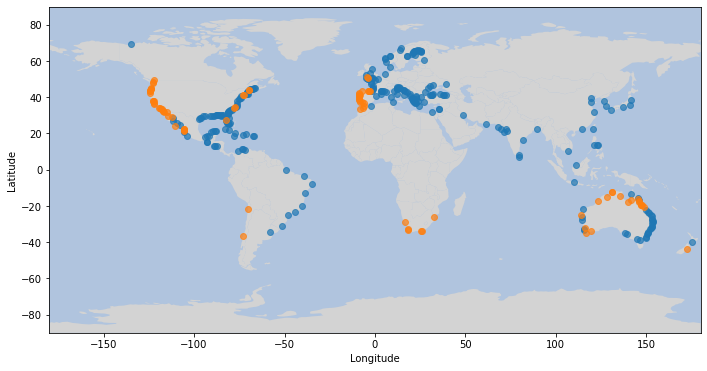

In [71]:
air_non_significant = b[b.trend_air == "no trend"].merge(estuary_shp, on='ID_NUMBER', how='left')
#air_non_significant=air_non_significant[air_non_significant.INPUT_LAT < 60]
air_significant = b[b.trend_air != "no trend"].merge(estuary_shp, on='ID_NUMBER', how='left')
#air_significant=air_significant[air_significant.INPUT_LAT < 60]

print(air_non_significant.shape)
print(air_significant.shape)
air_non_significant 

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting our Impact Energy data with a color map
x = air_significant['INPUT_LON']
y = air_significant['INPUT_LAT']

plt.scatter(x, y, alpha=0.7)

c = air_non_significant['INPUT_LON']
d = air_non_significant['INPUT_LAT']

plt.scatter(c, d, alpha=0.7)
# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig('map of air trend.png')
plt.show()

In [72]:
#Discharge, size, Latitude, Air temperature, and Warming rate

air_non_significant['dis_size'] = np.log10(air_non_significant['DISCHARGE']/air_non_significant['Area_km2'])
air_non_significant['log_slope']=np.log10(air_non_significant['slope'])

b = air_non_significant[['log_slope', 'dis_size']].replace([np.inf, -np.inf], np.nan).dropna()
print(stats.pearsonr(b['dis_size'], b['log_slope']))


(0.27505659414846184, 0.014800532914979332)


In [73]:
air_significant['dis_size'] = np.log10(air_significant['DISCHARGE']/air_significant['Area_km2'])
air_significant['log_slope']=np.log10(air_significant['slope'])

b = air_significant[['log_slope', 'dis_size']].replace([np.inf, -np.inf], np.nan).dropna()
print(stats.pearsonr(b['dis_size'], b['log_slope']))

(0.32832587736468, 1.9415319053707612e-07)


In [ ]:
f= air_temp.merge(year, on='key', how='left')
f = f.dropna()
f["$Annual Mean Air Temperature {^\circ}C$"] = f['mean_2m_air_temperature']
f["$ Annual Mean Water Temperature {^\circ}C$"] = f['Corrected_LS_Temp']
print(f[['Corrected_LS_Temp', 'mean_2m_air_temperature']].corr())
print(f.shape)
print(rlm_results.summary())

y = f.Corrected_LS_Temp
x = f.mean_2m_air_temperature

rlm_model = sm.OLS(y, sm.add_constant(x))
rlm_results = rlm_model.fit()

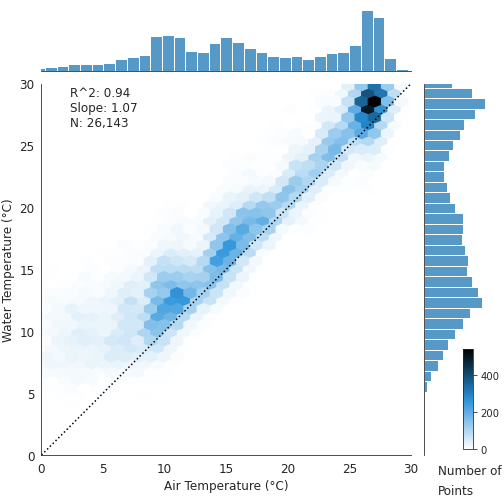

In [66]:
with sns.axes_style('white'):
    
    g = sns.jointplot(f["$Annual Mean Air Temperature {^\circ}C$"],f["$ Annual Mean Water Temperature {^\circ}C$"], kind='hex', xlim = (0,30), ylim = (0,30), size = 7)
    g.ax_joint.plot(np.linspace(0, 30),np.linspace(0, 30), ':k')
    cbar_ax = g.fig.add_axes([0.93,0.1,0.02,0.20])  # x, y, width, height
    plt.colorbar(cax=cbar_ax, shrink=0.9, pad =2)
    g.fig.text(0.15, 0.74, 'N: 26,143', fontsize = 12)
    g.fig.text(0.15, 0.77, 'Slope: 1.07', fontsize = 12)
    g.fig.text(0.88, 0.05, 'Number of', fontsize = 12)
    g.fig.text(0.88, 0.01, 'Points', fontsize = 12)
    g.fig.text(0.15, 0.8, 'R^2: 0.94', fontsize = 12)
    g.ax_joint.set_xlabel('Air Temperature (°C)', fontsize = 12)
    g.ax_joint.set_ylabel('Water Temperature (°C)', fontsize = 12)
    g.ax_joint.tick_params(axis="both", labelsize=12)
    plt.savefig('fig4_a.png')

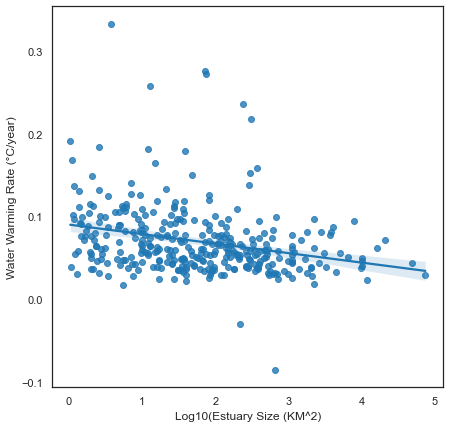

In [75]:
seaborn.set_theme(style='white')
sns.set_palette("tab10")

fig, ax = plt.subplots(figsize=(7, 7))
x = np.log10(test_each_estuary.Area_km2)
y = test_each_estuary.slope

viol_plot = sns.regplot( x=x, y=y)

viol_plot.set_xlabel('Log10(Estuary Size (KM^2)', fontsize = 12)
viol_plot.set_ylabel('Water Warming Rate (°C/year)', fontsize = 12)
plt.savefig('slope and size.png')

In [76]:
x = np.log10(test_each_estuary.Area_km2)
y = test_each_estuary.slope

rlm_model = sm.OLS(y, sm.add_constant(x))
rlm_results = rlm_model.fit()
print(rlm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  slope   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     28.22
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           1.94e-07
Time:                        19:01:23   Log-Likelihood:                 624.73
No. Observations:                 348   AIC:                            -1245.
Df Residuals:                     346   BIC:                            -1238.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0903      0.004     20.646      0.0

In [38]:
# Test if they are statistically different or not.
list_estuary = study_estuaries 
list_estuary['Latitude Zone'].unique()
a=list_estuary[list_estuary['Latitude Zone'] == '30-60 N ']['slope']
b=list_estuary[list_estuary['Latitude Zone'] == '0-30 N']['slope']
c=list_estuary[list_estuary['Latitude Zone'] == '60-90 N']['slope']
d=list_estuary[list_estuary['Latitude Zone'] == '60-30 S ']['slope']
e=list_estuary[list_estuary['Latitude Zone'] == '30-0 S']['slope']

from scipy import stats
print(stats.kruskal(a,b,c,d,e))

NA = list_estuary[list_estuary['CONTINENT'].isnull()]['slope']
AF = list_estuary[list_estuary['CONTINENT'] == 'AF']['slope']
AS = list_estuary[list_estuary['CONTINENT'] == 'AS']['slope']
SA = list_estuary[list_estuary['CONTINENT'] == 'SA']['slope']
AU = list_estuary[list_estuary['CONTINENT'] == 'AU']['slope']
EU = list_estuary[list_estuary['CONTINENT'] == 'EU']['slope']
print(stats.kruskal(NA, AF, AS,SA,AU,EU))

KruskalResult(statistic=109.93553770434917, pvalue=7.511718407519517e-23)
KruskalResult(statistic=149.99268942631176, pvalue=1.3399304644045367e-30)


In [32]:
print(NA.describe())

count    124.000000
mean       0.055692
std        0.019196
min        0.023384
25%        0.042688
50%        0.053619
75%        0.063047
max        0.137353
Name: slope, dtype: float64


In [33]:
print(SA.describe())

count    15.000000
mean      0.054317
std       0.032770
min      -0.029680
25%       0.037750
50%       0.060814
75%       0.077710
max       0.103273
Name: slope, dtype: float64


In [34]:
print(AS.describe())

count    39.000000
mean      0.082538
std       0.052052
min      -0.084821
25%       0.053570
50%       0.080418
75%       0.097299
max       0.217224
Name: slope, dtype: float64


In [35]:
print(EU.describe())

count    108.000000
mean       0.099489
std        0.048828
min        0.028108
25%        0.071582
50%        0.088605
75%        0.111011
max        0.333085
Name: slope, dtype: float64


In [36]:
print(AF.describe())

count    11.000000
mean      0.056335
std       0.027540
min       0.027931
25%       0.036215
50%       0.047337
75%       0.061044
max       0.108595
Name: slope, dtype: float64


In [39]:
print(AU.describe())

count    51.000000
mean      0.040796
std       0.012062
min       0.016853
25%       0.034123
50%       0.039279
75%       0.047722
max       0.082622
Name: slope, dtype: float64


In [27]:
AU = list_estuary[list_estuary['CONTINENT'] == 'AU']
AU.columns

AU_west = AU[AU['INPUT_LON'] < 135]
print(AU_west.shape)
print(AU_west.slope.median())
AU_east = AU[AU['INPUT_LON'] > 135]
print(AU_east.shape)
print(AU_east.slope.median())

stats.mannwhitneyu(AU_east['slope'],AU_west['slope'], alternative='greater')

(13, 30)
0.0360299013161775
(38, 30)
0.044290771591370806


MannwhitneyuResult(statistic=375.0, pvalue=0.0029281227359153677)

In [29]:
list_estuary.groupby(['Latitude Zone']).size()

Latitude Zone
0-30 N       75
30-0 S       42
30-60 N     181
60-30 S      27
60-90 N      23
dtype: int64

In [21]:
#Chesapeake Bay 
test_each_estuary[test_each_estuary.ID_NUMBER == 306][['LABEL', 'slope']]

,LABEL,slope
176,Chesapeake Bay,0.049749


In [24]:
#Florida
test_each_estuary[test_each_estuary.ID_NUMBER.isin([1330, 296,297,1333,1334,1332,295])][['LABEL', 'slope']]
print(test_each_estuary[test_each_estuary.ID_NUMBER.isin([1330, 296,297,1333,1334,1332,295])][['LABEL', 'slope']]['slope'].median())

0.0568403703107295
